In [8]:
from flax import optim
import jax
from typing import Any, Callable, Sequence, Optional
from jax import lax, numpy as jnp
from jax import vmap, jit
import jax.random as jrandom

from flax import optim
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn

import optax
from optax import softmax_cross_entropy
import numpy as np

from jax.config import config
config.enable_omnistaging() # Linen requires enabling omnistaging

import collections

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch

import cProfile
from memory_profiler import profile
import jax.profiler

import gc
gc.enable()

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.8/site-packages/jax/_src/config.py:163: UserWarning: enable_omnistaging() is a no-op in JAX versions 0.2.12 and higher;
see https://github.com/google/jax/blob/main/design_notes/omnistaging.md
  warnings.warn(


In [9]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [10]:
import rubikenv

In [11]:
import rubikenv.rubikgym as rb

In [12]:
rubik = rb.rubikgym()
rubik.render()


[[[0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]

 [[0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]

 [[0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]]


In [13]:
rubik.step(4)
rubik.render()

[[[4 1 5 3 2 0]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]

 [[4 1 5 3 2 0]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]

 [[4 1 5 3 2 0]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]]


In [14]:
rubik.step(6)
rubik.render()

[[[0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]

 [[0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]

 [[0 1 2 3 4 5]
  [0 1 2 3 4 5]
  [0 1 2 3 4 5]]]


In [68]:
%%time
env = rb.rubikgym()
obs, done = env.reset(), False
episode_rew = 0
nb_iter = 14

## action list
#actions = jrandom.randint(key1, shape=(nb_iter,1), minval=0, maxval=12)
actions = np.random.randint(0, 12, size=(nb_iter,1))

## state list
obs_list = []

for q in range(nb_iter):

    obs, rew, done, _ = env.step(actions[q, 0])
    obs_list.append(obs)
    
    

CPU times: user 5.19 ms, sys: 0 ns, total: 5.19 ms
Wall time: 2.79 ms


In [88]:
## First we can try to solve it using "classic machine learning"
## conversion action => on hot encoder

from flax import linen as nn

class Model_rubik(nn.Module):

    features = (2048, 512, 12)

    def setup(self):
        self.dense1 = nn.Dense(self.features[0])
        self.dense2 = nn.Dense(self.features[1])
        self.dense3 = nn.Dense(self.features[2])

    def __call__(self, x):
        x = nn.relu(self.dense1(x))
        x = nn.relu(self.dense2(x))
        x = self.dense3(x)
        return x

model_rubik = Model_rubik()
    
key1, key2 = jrandom.split(jrandom.PRNGKey(0))
x = jrandom.normal(key1, (54*6,)) # Dummy input
params = model_rubik.init(key2, x) # Initialization call
    
#### action help
def encoder_one_hot_action(action):
    """
    Encode the action into a one hot encoder vector
    """
    
    action_encode = jnp.zeros(12)
    action_encode = jax.ops.index_update(action_encode, jax.ops.index[action], 1)

    return action_encode

def encoder_decode_action(action_encode):
    """
    Decode from one hot to int value
    """
    action = jnp.argmax(action_encode)
    
    return action

#### state help
def encoder_one_hot_state(state):
    """
    Encode the action into a one hot encoder vector
    """
    
    state = jnp.array(state)
    state = jnp.ravel(state)
    
    state_encode = jnp.zeros((54, 6))
    
    for idx, i in enumerate(state):
        state_encode = jax.ops.index_update(state_encode, jax.ops.index[idx, i], 1)

    return jnp.ravel(state_encode), state_encode

def encoder_decode_state(state_encode):
    """
    Decode from one hot to int value
    """
    state = jnp.argmax(state_encode, axis=1)
    
    return state

def compute_inverse_action(action):
    pos = (action // 4) 
    inv_pos = (action - pos*4)
    inv_pos_new = (inv_pos  + 2) % 4
    
    return pos*4 + inv_pos_new 

reverse_list = vmap(compute_inverse_action)

encoder_one_hot_action_action = vmap(encoder_one_hot_action)
encoder_one_hot_state_vector = vmap(encoder_one_hot_state)

nb_iter = 15

def compute_random_suffle(dumpy_value):
    
    env.reset()
    episode_rew = 0
    
    ## action list
    #actions = jrandom.randint(key1, shape=(nb_iter,1), minval=0, maxval=12)
    actions = np.random.randint(0, 12, size=(nb_iter,1))
    
    ## state list
    obs_list = []
    
    for q in range(nb_iter):
        
        obs, rew, done, _ = env.step(actions[q, 0])
        obs_list.append(obs.copy())
        
        ## we should also compute the max of the model
    
    ### we compute the reverse action
    
    return jnp.array(obs_list), reverse_list(actions)

35831808

### testing part

In [89]:
%%time
## testing results
encode_vector = encoder_one_hot_action(0)
encoder_decode_action(encode_vector)

encoded, encoded_hot = encoder_one_hot_state(obs)
encoder_decode_state(encoded_hot)

## computer result
for i in range(10):
    list_obs, actions = compute_random_suffle(0)

CPU times: user 255 ms, sys: 16 ms, total: 271 ms
Wall time: 335 ms


### Generation part

In [11]:
def flattenx(x):
    return jnp.ravel(x)

flatten_all = vmap(flattenx)

def generate_dataset(nb_iter_main_loop=100):

    actions_all = []
    obs_all = []

    for _ in range(nb_iter_main_loop):

        # train on main loop
        list_obs, actions = compute_random_suffle(0)

        # process for training
        actions_all.append(actions)
        obs_all.append(list_obs)
        
    obs_all = jnp.concatenate(obs_all)
    actions_all = jnp.concatenate(actions_all)
    
    obs_all, second = encoder_one_hot_state_vector(obs_all)
    actions_all = encoder_one_hot_action_action(actions_all)
        
    return obs_all, actions_all

In [12]:
%%time
obs_all, actions_all = generate_dataset()

dataset = TensorDataset(torch.from_numpy(np.array(obs_all)), torch.from_numpy(np.array(actions_all)))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


CPU times: user 1.88 s, sys: 69.5 ms, total: 1.95 s
Wall time: 1.95 s


In [13]:
optax.__version__

'0.0.8'

### Optax optimization

In [16]:
%%time
loss_hist = []

optimizer = optax.adam(0.001)
opt_state = optimizer.init(params)

nb_epoch = 1
nb_round_generation = 20
size_generation = 10000

# label smoothing
smooth_vec = vmap(optax.smooth_labels, in_axes=(0, None))

# cross entropy logit accelearation
softmax_logit = vmap(optax.softmax_cross_entropy)

def loss_fn(params_, obs_, actions_):
    
    pred =  model_rubik.apply(params_, obs_)
    
    actions_ = smooth_vec(actions_, 0.1)
    
    error = softmax_logit(pred, actions_)
    loss = jnp.mean(error)
    return loss

loss_grad_fn = jax.value_and_grad(loss_fn, argnums=0)
i = 0       

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 13.3 ms


In [17]:
%%time

loss_hist = []

for q in range(nb_round_generation):

    print("New generation")
    
    obs_all, actions_all = generate_dataset(size_generation)

    dataset = TensorDataset(torch.from_numpy(np.array(obs_all)), torch.from_numpy(np.array(actions_all)))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    for p in range(nb_epoch):
        
        print("epoch")
        
        for obs, actions in dataloader:

            obs = jnp.array(obs)
            actions = jnp.array(actions)
            
            # optimizer application
            loss_val, grad = loss_grad_fn(params, obs, actions)
            updates, opt_state = optimizer.update(grad, opt_state, params)  # transform & update stats.
            params = optax.apply_updates(params, updates)
            
            params = jax.lax.stop_gradient(params)
            
            loss_val = jax.lax.stop_gradient(loss_val)
            loss_hist.append(loss_val)
            
            
        #jax.profiler.save_device_memory_profile(f"memory{p}_{q}.prof")


                

New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
New generation
epoch
CPU times: user 1h 49min 15s, sys: 3min 13s, total: 1h 52min 29s
Wall time: 1h 52min 37s


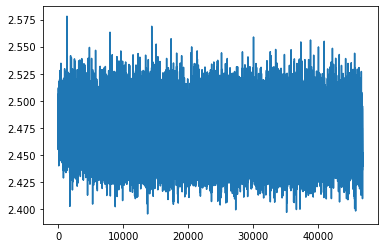

In [18]:
plt.plot(loss_hist)

In [29]:
for obs, actions in dataloader:
    obs = jnp.array(obs)
    actions = jnp.array(actions)

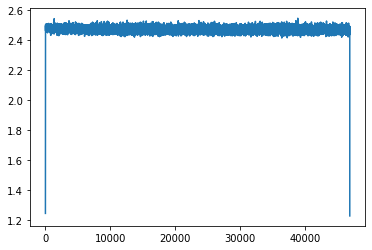

In [21]:
loss_hist_conv = np.convolve(loss_hist, [0.5, 0.5])
plt.plot(loss_hist_conv)

In [22]:
pred =  model_rubik.apply(params, obs)
actions_ = smooth_vec(actions, 0.1)

In [25]:
nn.softmax(pred)

DeviceArray([[0.09903321, 0.08787514, 0.08926631, 0.08605015, 0.08034284,
              0.06552635, 0.06811097, 0.06499642, 0.09200169, 0.1011763 ,
              0.08150456, 0.08411605],
             [0.10682761, 0.10357153, 0.06999954, 0.07109042, 0.07530154,
              0.07431918, 0.08099779, 0.07826633, 0.08903639, 0.10012593,
              0.07807752, 0.07238621],
             [0.07672944, 0.07264872, 0.09520233, 0.0920278 , 0.09225721,
              0.0930339 , 0.0670476 , 0.06639387, 0.09805148, 0.10108283,
              0.07162858, 0.07389628],
             [0.06730958, 0.09576166, 0.06023575, 0.09076031, 0.08790235,
              0.09479324, 0.08473118, 0.08822805, 0.06271711, 0.11779445,
              0.05817367, 0.09159273],
             [0.08294633, 0.08075906, 0.08588978, 0.08141427, 0.0940852 ,
              0.09452771, 0.07246183, 0.06956102, 0.08358623, 0.08547929,
              0.08135758, 0.08793172],
             [0.10402488, 0.07774901, 0.08472954, 0.06418136, 0.0